copy of [2017-10-24-frequency-entrainement](2017-10-24-frequency-entrainement.ipynb)

In [1]:
import sys
sys.path.append('../libs/')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from mean_field_model import *
from scipy import signal
from matplotlib import gridspec
from matplotlib import transforms

# Simulate a pair of coupled oscillators driven by stimulus

In [3]:
uV = 1e-6 * V
nV = 1e-9 * V

In [4]:
tau_adapt = 800 * ms # adaptation time constant
beta_adapt = 0.00005*mV / Hz # strength of adaptation (per firing rate of E population)
gamma_ephaptic = -100 * uV / (6000*Hz) # ephaptic coupling coefficient
dt = 1 * ms # integration time step
tau_e = 10*ms # time constant of excitatory population
tau_i = 5* ms # time constant of inhibitory population
threshold_inh0 = -51 * mV # inhibitory threshold

Define the system of three differential equations describing E population, I population and adaptation potential:

$$\tau_e\frac{\nu_e}{dt}=-\nu_e+n_ef_e(\nu_e+\nu_{\mathrm{ext}}, \nu_i)  + \sigma_{\mathrm{e}}\eta_t \\
\tau_i\frac{\nu_i}{dt}=-\nu_i+ n_i f_i(\nu_e+\nu_{\mathrm{ext}}, \nu_i)+ \sigma_{\mathrm{i}}\eta_t \\
\tau_{\mathrm{adapt}}\frac{dU_{\mathrm{adapt}}}{dt}=-U_{\mathrm{adapt}} + \beta \nu_{exc}$$


In [5]:
def solve_ei_dynamics(f_ext, n_e, n_i, threshold_exc, threshold_inh, tau_e=1*s, tau_i=1*s):
    def _update(rinh, rexc, ephaptic, theta_adapt, external):
        fexc, finh = calc_output_rate_inh_exc(rexc + f_ext + external, rinh, n_e, n_i, 
                               threshold_exc + theta_adapt - ephaptic, threshold_inh)
        rinh += (-rinh + finh) * dt / tau_i
        rexc += (-rexc + fexc) * dt / tau_e
        theta_adapt += (-(theta_adapt + 0.0 * mV) +  beta_adapt * rexc) * dt / tau_adapt
        
        return rinh, rexc, theta_adapt
    return _update


Simulate a pair of E/I populations coupled through the electric field. The coupling is between the excitatory firing rate of one population and membrane potential of the other.

In [6]:
f_ext0 = 1000. # external firing rate


def single_trial(update_func, external_drive, noise_e, noise_i, tmax, gamma_ephaptic):


    rexc = np.ones(2) * 100 * Hz
    rinh = np.ones(2) * 100 * Hz
    theta_adapt = np.zeros(2) * mV
    t = 0
    solution= []
    while t < tmax:
        rexc_old0, rexc_old1 = rexc[0], rexc[1]
        rexc += np.random.randn(2) * noise_e
        rinh += np.random.randn(2) * noise_i
        rexc = np.maximum(rexc, 0)
        rinh = np.maximum(rinh, 0)
        rinh[0], rexc[0], theta_adapt[0] = update_func(rinh[0], 
                                                       rexc[0],
                                                       0, #gamma_ephaptic * rexc_old1,
                                                       theta_adapt[0],
                                                       external_drive(t))
        rinh[1], rexc[1], theta_adapt[1] = update_func(rinh[1],
                                                       rexc[1],
                                                       gamma_ephaptic * rexc_old0,
                                                       theta_adapt[1],
                                                       0)
        


        t += dt
        solution.append((rexc, rinh, theta_adapt.copy()))
    solution = np.array(solution)
    return solution

In [7]:
def square_wave(amplitude, period, duration, delay=0):
    def _value(t):
        return amplitude * (np.mod(t, period) < duration) * (t > delay)
    return _value

## Sample stimulation protocol

To simulate the glutamate injections in the experimental protocol, in the mode we trigger UP states by depolarising excitatory population. This is repeated periodically with a given frequency. The duration of a single stimulation pulse is 0.35 s.

In [8]:
depolarisation_glutamate =  1000. * Hz
glutamate_delay = 10.
glutamate_frequency = 1. * Hz
glutamate_duration = 0.35 * s
glutamate_application = square_wave(depolarisation_glutamate,
                                    1./glutamate_frequency,
                                    glutamate_duration,
                                    glutamate_delay)
update_func = solve_ei_dynamics(f_ext0, n_e, n_i, threshold, threshold_inh0,  tau_e=tau_e, tau_i=tau_i)

noise_e, noise_i = 2000 * Hz / s * np.sqrt(dt), 0
tmax = 100 * s
solution = single_trial(update_func, glutamate_application, noise_e, noise_i, tmax, gamma_ephaptic)

Text(0.5,0,'time, s')

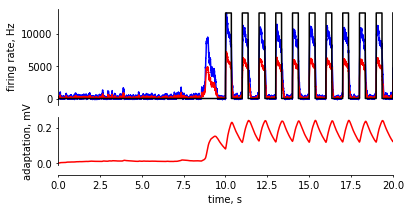

In [9]:
gs = gridspec.GridSpec(3,1, height_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[0])

time = np.arange(solution.shape[0]) * dt
glu_signal = glutamate_application(time)
lines = plt.plot(time, solution[:, 0, 0], 'b')
lines = plt.plot(time, solution[:, 1, 0], 'r')
plt.plot(time, glu_signal / depolarisation_glutamate * solution[:, 0, 0].max(), 'k-')

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('left')
ax1.yaxis.set_tick_params(length=2)
plt.setp(ax1.xaxis.get_ticklabels(), visible=False)
plt.ylabel('firing rate, Hz')

ax2 = plt.subplot(gs[1], sharex=ax1)
plt.plot(time, solution[:, 2, 0] / mV, '-r')
plt.ylabel('adaptation, mV')
plt.xlim(0, 20)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position(('outward', 10))
ax2.yaxis.set_tick_params(length=2)
ax2.xaxis.set_tick_params(length=2)
plt.xlabel('time, s')

**Supplementary Figure** Top: The total population firing rates of the excitatory (blue) and inhibitory (red) together with the train of stimulations triggering UP states (black). Bottom: The trace of adaptation variable.

## Low-pass filter

To obtain band-limited signals corresponding to the UP/DOWN oscillation frequency, we low-pass filter the population firing rates. We design an infinite impulse response filter (IIR) using SciPy methods with the frequency band of [0, 5] Hz (order 17). Next, we apply the filter both directions (forward and backward) using SciPy's `filtfilt` method.

In [10]:
n_subsamp = 10
y = solution[::n_subsamp, 0, :].copy()
time_subsamp = time[::n_subsamp]
filter_order = 17
cutoff_frequency = 5.
sampling_frequency = 1 / (dt * n_subsamp)
b, a = signal.iirfilter(filter_order,  cutoff_frequency * 2 / sampling_frequency, btype='lowpass')
y_filtered = signal.filtfilt(b, a, y[:], axis=0)

Text(0,0.5,'filter gain')

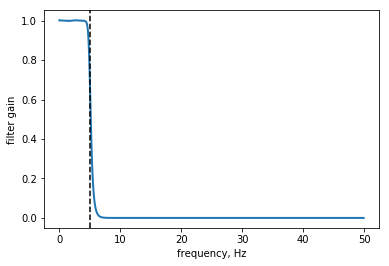

In [11]:
f, resp = signal.freqz(b, a)
plt.plot(f / (2 * np.pi) * sampling_frequency, np.abs(resp), lw=2)
plt.axvline(cutoff_frequency, ls='--', color='k')
plt.xlabel('frequency, Hz')
plt.ylabel('filter gain')

**Supplementary Figure** Frequency response of the designed IIR filter. Dashed line shows the cutoff frequency

Text(0.5,0,'time, s')

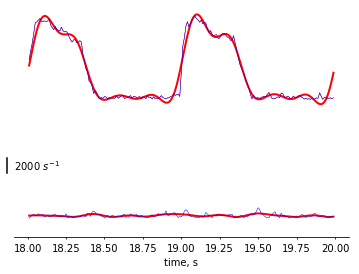

In [12]:
tsel = (time_subsamp > 18) & (time_subsamp < (20. * s))
ax1 = plt.subplot(211)
plt.plot(time_subsamp[tsel], y[tsel, 0], 'r-', lw=0.5)
plt.plot(time_subsamp[tsel], y_filtered[tsel, 0], 'r', lw=2)
plt.plot(time_subsamp[tsel], y[tsel, 0], 'b-', lw=0.5)

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
plt.setp(ax1.xaxis.get_ticklabels(), visible=False)
plt.setp(ax1.yaxis.get_ticklabels(), visible=False)

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(time_subsamp[tsel], y_filtered[tsel, 1], 'r', lw=2)
plt.plot(time_subsamp[tsel], y[tsel, 1], 'b-', lw=0.5)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('outward', 10))
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_tick_params(length=2)
plt.setp(ax2.yaxis.get_ticklabels(), visible=False)

trans = transforms.blended_transform_factory(ax2.transAxes, ax2.transData)
plt.plot([-0.02, -0.02], [6000, 8000], 'k-', transform=trans, clip_on=False)
plt.text(-0.0, 7000, '2000 $s^{-1}$', ha='left', va='center', transform=trans)
plt.xlabel('time, s')

**Supplementary Figure** Filtered population rates (thick red) superimposed on the raw population rates (thin blue) for two excitatory populations.

## Detect UP states

We detected the UP states by identifying points at which the excitatory population rate exceeds a threshold (equal to the standard deviation of the rate). These points correspond to DOWN-to-UP transitions.

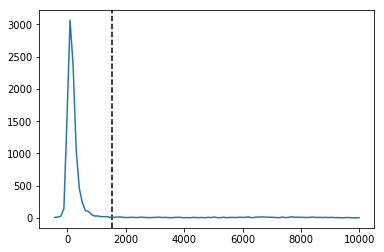

In [13]:
y_signal = y_filtered[:, 1]
y_std = np.std(y_signal)
n, x = np.histogram(y_signal, 100)
plt.axvline(y_std, ls='--', color='k')
plt.plot(x[:-1], n)

(0, 60)

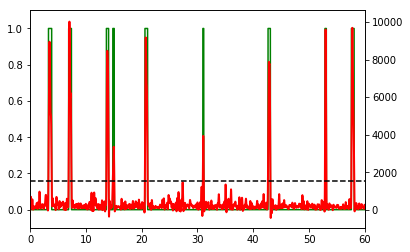

In [14]:
detection_threshold = y_std
upstates = (y_signal > detection_threshold).astype(int)
plt.plot(time_subsamp, upstates, 'g')
plt.ylim(-0.1, 1.1)
plt.twinx()
plt.plot(time_subsamp, y_signal, 'r', lw=2)
plt.axhline(detection_threshold, color='k', ls='--')
plt.xlim(0, 60)

In [15]:
upstates.shape

(10000,)

19 0.1900190019


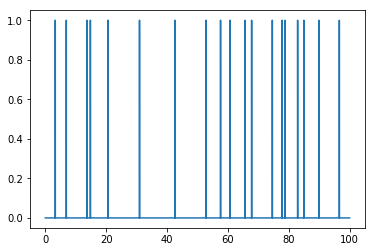

In [16]:
downup = np.diff(upstates)
downup[downup < 0] = 0
n_downup = np.sum(downup)
freq_downup = n_downup / time_subsamp.max()
plt.plot(time_subsamp[:-1], (downup))
#plt.xlim(0, 20)
print(n_downup, freq_downup)

In [17]:
def detect_upstates(y_signal):
    y_std = np.std(y_signal)
    detection_threshold = y_std
    upstates = (y_signal > detection_threshold).astype(int)
    downup = np.diff(upstates)
    indices, = np.where(downup > 0)
    return indices

# Dependency on stimulation frequency

In [18]:
population_colors = ['y', 'g']

## Sweep through stimulation frequencies

In [19]:
def calc_pli(y):
    """
    y - last axis has a dimension of 2 and contains signals from two different oscillators
    """
    
    phases = np.angle(signal.hilbert(y, axis=0))
    pli = np.abs(np.mean(np.exp(np.diff(phases, 1)*1j)))
    return pli   

Simulate the coupled populations model with the stimulation for a range of stimulation frequencies from 0.1 to 1 Hz.

In [20]:
stimulation_frequencies = np.linspace(0.1, 1., 11.)

filtered_signals = []
glu_signals = []
for gl_freq in stimulation_frequencies:
    glutamate_application = square_wave(depolarisation_glutamate, 1./gl_freq, glutamate_duration, glutamate_delay)

    tmax = 200 * s
    solution = single_trial(update_func, glutamate_application, noise_e, noise_i, tmax, gamma_ephaptic)
    
    y = solution[::n_subsamp, 0, :].copy()
    
    y_filtered = signal.filtfilt(b, a, y[:], axis=0)
    i0 = int(glutamate_delay / (dt * n_subsamp))
    y_oscillations = y_filtered[i0:, :]
    
    filtered_signals.append(y_oscillations)
    
    time = np.arange(solution.shape[0]) * dt
    time = time[::n_subsamp][i0:]
    glu_signals.append(glutamate_application(time))
    
filtered_signals = np.array(filtered_signals)
glu_signals = np.array(glu_signals)

/home/bartosz/.pyenv/versions/ephaptic_test_3/lib/python3.6/site-packages/ipykernel-5.1.0-py3.6.egg/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


## Plot: sample excitatory rates of the two populations

We plot sample excitatory rates from both populations for three different stimulation frequencies.

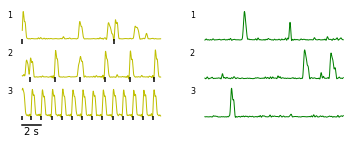

In [21]:
import matplotlib

line_colors = matplotlib.cycler('color', population_colors)
trace_samples_idx =  [0, 3, 9]

n_points = 1500
with matplotlib.style.context({'axes.prop_cycle':line_colors}):
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=False,
                             subplot_kw={'frameon':False},
                            figsize=(6, 2))
    for i in range(len(trace_samples_idx)):
        ax = axes[i, :]
        i_sig = trace_samples_idx[i]
        ampl = filtered_signals[i_sig, :n_points, :].max()
        glu_trace = glu_signals[i_sig, :n_points]
        t_upstates = detect_upstates(glu_trace)
        
        
        #ax[0].plot(glu_trace / glu_trace.max() * ampl, 'r-')
        ax[0].plot(filtered_signals[i_sig, :n_points, 0], lw=1,
                   color=population_colors[0])
        ax[1].plot(filtered_signals[i_sig, :n_points, 1], lw=1,
                   color=population_colors[1])
        trans = transforms.blended_transform_factory(ax[0].transData,
                                                     ax[0].transAxes)
        ax[0].vlines(t_upstates, -0.05, 0.1, transform=trans,
                     zorder=10, lw=1.5, clip_on=False)
        for a in ax:
            a.xaxis.set_ticks_position('none')
            a.yaxis.set_ticks_position('none')
            a.yaxis.set_ticks([])
            a.xaxis.set_ticks([])
            a.text(-0.02, 1, str(i+1), transform=a.transAxes, va='top', ha='right', size=8)
    trans = transforms.blended_transform_factory(axes[-1, 0].transData,
                                                 axes[-1, 0].transAxes)
    axes[-1, 0].plot([0, 2 / (dt * n_subsamp) ], [-0.2, -0.2], 'k', lw=1.5,
                    transform=trans, clip_on=False)
    axes[-1, 0].text(1. / (dt * n_subsamp), -0.25, '2 s', ha='center', va='top',
                    transform=trans, clip_on=False)
plt.savefig('figures/sync_traces.svg')

## Plot: phase locking index vs. stimulation frequency

Phase locking index is a measure of synchronisation between two oscillators. PLI close to 0 means that the oscillators are independent and their phases are not locked. PLI equal to 1 corresponds to perfect synchronisation.

In [22]:
pli_vs_freq = []
for y_oscillations in filtered_signals:
    pli = calc_pli(y_oscillations)
    pli_vs_freq.append(pli)
pli_vs_freq = np.array(pli_vs_freq)

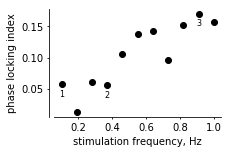

In [23]:

matplotlib.rcParams['xtick.major.size'] = 2.
matplotlib.rcParams['ytick.major.size'] = 2.
plt.figure(figsize=(3,2))
ax = plt.subplot()
plt.plot(stimulation_frequencies, pli_vs_freq,'ko', clip_on=False)
plt.xlabel('stimulation frequency, Hz')
plt.ylabel('phase locking index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['left'].set_position(('outward', 5))

for i, idx in enumerate(trace_samples_idx):
    plt.annotate(str(i+1), (stimulation_frequencies[idx], pli_vs_freq[idx]),
                         (0, -5),
                 textcoords='offset points',
                 ha='center', va='top',
                 size=8)
plt.savefig('figures/pli_vs_freq.svg')

## Plot: Frequency of UP states vs. stimulatin frequency

Count the UP states and plot their frequency vs. the stimulation frequency.

In [24]:
def count_upstates(y_signal):
    y_std = np.std(y_signal)
    detection_threshold = y_std
    upstates = (y_signal > detection_threshold).astype(int)
    downup = np.diff(upstates)
    downup[downup < 0] = 0
    n_downup = np.sum(downup)
    return n_downup

In [25]:
n_upstates = []
for y_oscillations in filtered_signals:
    nup1 = count_upstates(y_oscillations[:, 0])
    nup2 = count_upstates(y_oscillations[:, 1])
    n_upstates.append((nup1, nup2))
n_upstates = np.array(n_upstates)


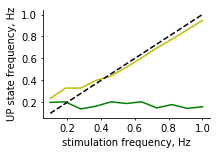

In [26]:
import matplotlib
plt.figure(figsize=(3,2))

line_colors = matplotlib.cycler('color', population_colors)
with matplotlib.style.context({'axes.prop_cycle':line_colors}):
    ax = plt.subplot(111)
    ax.plot(stimulation_frequencies, n_upstates * 1. / tmax, lw=1.5)
    ax.plot(stimulation_frequencies, stimulation_frequencies, 'k--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.xlabel('stimulation frequency, Hz')
    plt.ylabel('UP state frequency, Hz')
plt.savefig('figures/up_state_frequency.svg')

# Final figure

In [31]:
from svgutils import compose as sc

In [32]:
fig = sc.Figure('16cm', '9cm',
        sc.Panel(
          sc.SVG('figures/sync_traces.svg'),
          sc.Text('B', 30, 20, size=14)
        ).move(100, 0),
        sc.Panel(
          sc.Text('D', 0, 0, size=14),
          sc.SVG('figures/pli_vs_freq.svg')
        ).move(260, 160),
        sc.Panel(
          sc.Text('A', 0, -10, size=14),
          sc.SVG('figures/entrained-schematics.svg'
          ).scale(0.6)
        ).move(0, 30),
        sc.Panel(
          sc.Text('C', 0, 0, size=14),
          sc.SVG('figures/up_state_frequency.svg')        
        ).move(20, 160)
    )

In [33]:
from IPython.display import SVG, display

In [34]:
fig.save('figures/inverted_slices_composed.svg')

In [35]:
svg = SVG(filename='figures/inverted_slices_composed.svg')
display(svg)

**Figure** Entrainment of the UP-DOWN oscillations to the periodic glutamate stimulation on both sides of the sectioned slice.  ( **A** ) Schematics of the stimulation protocol. In the model glutamate injection (Stim) is applied on the right side of the slice (green) triggering periodic UP states on both sides (yellow). ( **B** ) Sample traces of excitatory population rate (color coded, compare with (A)) on both sides of the slice at three stimulation frequencies (red line, see the numbers in (B) and (C) for the values of the frequencies). ( **C** ) The frequency of the UP states in both parts of the slice is shown as the function of stimulation frequency (color code same as in (A)).  Slice to the left of the cut frequency-locks to the stimulation by means of the electric-field (ephaptic) coupling. ( **D** ) The precision of the entrainment depends on the frequency of the glutamate injection (stimulation frequency) as quantified by the phase locking index (PLI). Larger PLI indicates stronger synchronisation. 